# NFL Big Data Bowl Clustering

## Import data

In [1]:
import pandas as pd

In [2]:
plays = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/plays.csv')
games = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/games.csv')
players = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/players.csv')
tracking2018 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/fg_tracking_2018.csv')
tracking2019 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/fg_tracking_2019.csv')
tracking2020 = pd.read_csv('~/Documents/NFL/Data/nfl-big-data-bowl-2022/fg_tracking_2020.csv')

## Preprocess Players Data

In [3]:
from pipeline.preprocessing import preprocess_players

In [4]:
players_df = preprocess_players(players)

## Preprocess Tracking Data

In [5]:
from pipeline.preprocessing import preprocess_tracking, preprocess_football_track

In [6]:
fg_tracking_2018, fg_tracking_2019, fg_tracking_2020 = preprocess_tracking(tracking2018, tracking2019, tracking2020, plays, 'Field Goal')

In [7]:
fg_tracking_ball = preprocess_football_track(fg_tracking_2018, fg_tracking_2019, fg_tracking_2020)

## Preprocess Play Data

In [8]:
from pipeline.preprocessing import preprocess_play
from pipeline.preprocessing import drop_by_index_difference

In [9]:
play_df = preprocess_play(plays)

In [10]:
play_df = drop_by_index_difference(play_df, fg_tracking_ball, 'field_goal_attempt')

## Make Field Goal DataFrame

In [12]:
from pipeline.dataset_builders import make_field_goal

In [13]:
field_goal_df = make_field_goal(play_df, players_df)

## Feature Engineering

In [14]:
from pipeline.feature_engineering import endzone_y_pos, expected_endzone_y_pos, kicker_core_dist, exp_err_y, off_center

### Fieldgoal Y-Position

In [15]:
field_goal_df = endzone_y_pos(field_goal_df, fg_tracking_ball)

### Fieldgoal Trajectory Position

In [16]:
attempts_df = field_goal_df[field_goal_df['specialTeamsResult'].isin(['Kick Attempt Good', 'Kick Attempt No Good'])]

In [17]:
attempts_ids = attempts_df[['gameId', 'playId']]

In [18]:
attempts_tracking = pd.merge(attempts_ids, fg_tracking_ball, left_on = ['gameId', 'playId'], right_on = ['gameId', 'playId'])

In [19]:
attempts_event = attempts_tracking[attempts_tracking['event']=='field_goal_attempt']

In [20]:
attempts_event['mergeId'] = attempts_event['gameId'].astype(str) + attempts_event['playId'].astype(str)
attempts_ids['mergeId'] = attempts_ids['gameId'].astype(str) + attempts_ids['playId'].astype(str)

/tmp/ipykernel_117112/3006702610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_event['mergeId'] = attempts_event['gameId'].astype(str) + attempts_event['playId'].astype(str)
/tmp/ipykernel_117112/3006702610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_ids['mergeId'] = attempts_ids['gameId'].astype(str) + attempts_ids['playId'].astype(str)


In [21]:
indices_to_drop = attempts_ids[~attempts_ids['mergeId'].isin(attempts_event['mergeId'])].index

In [22]:
#fg_tracking_ball[(fg_tracking_ball['gameId']==2018122302) & (fg_tracking_ball['playId']==1858)]

In [23]:
#fg_tracking_ball = fg_tracking_ball.drop(indices_to_drop)

In [24]:
attempts_df = attempts_df.drop(indices_to_drop)

In [25]:
attempts_df = expected_endzone_y_pos(attempts_df, fg_tracking_ball, 'field_goal_attempt')

### Kicker Core Distance

While performing this compute, I discovered that it is apparently possible for a kicker not to be present for a play (???????????).

For an example of where this occurs, check out `gameId = 2019091502` and `playId = 2075` in the 2019 tracking data.

In [26]:
attempts_df = kicker_core_dist(attempts_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=3)

/home/kenneth/Documents/NFL/NFL_BDB_2022/pipeline/feature_engineering.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposing_team_players['kicker_dist'] = l2_norm(kicker_x, kicker_y, opposing_team_players['x'], opposing_team_players['y'])


In [27]:
attempts_df = kicker_core_dist(attempts_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=1)

### Endzone Y-Position Off-Center

In [28]:
attempts_df = off_center(attempts_df)

### Endzone Y-Position Trajectory Error

In [29]:
attempts_df = exp_err_y(attempts_df)

## Final Preprocessing Steps

In [30]:
from pipeline.preprocessing import preprocess_fg

In [31]:
X, final_df = preprocess_fg(attempts_df)

## Clustering

In [32]:
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
model = hdbscan.HDBSCAN()

In [34]:
model_results = model.fit(X)

In [35]:
model_results.labels_.max()

4

In [36]:
final_df['cluster_id'] = model_results.labels_

In [37]:
final_df['cluster_id'].value_counts()

 4    1836
-1     336
 2     112
 3      62
 0      14
 1      11
Name: cluster_id, dtype: int64

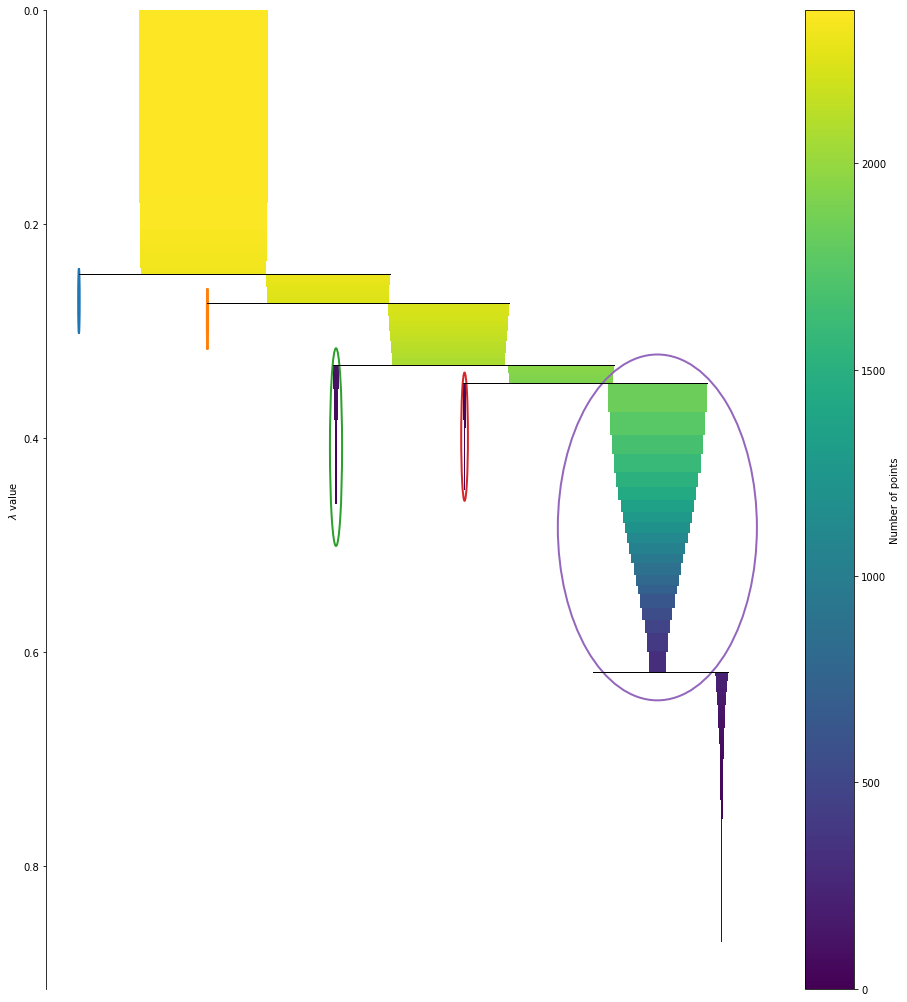

In [38]:
plt.figure(figsize = (16,18))
model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [39]:
cluster0 = final_df[final_df['cluster_id']==0]
cluster1 = final_df[final_df['cluster_id']==1]
cluster2 = final_df[final_df['cluster_id']==2]
cluster3 = final_df[final_df['cluster_id']==3]
cluster4 = final_df[final_df['cluster_id']==4]

outliers = final_df[final_df['cluster_id']==-1]

In [40]:
cluster0['specialTeamsResult'].value_counts()

Kick Attempt Good    14
Name: specialTeamsResult, dtype: int64

In [41]:
cluster1['specialTeamsResult'].value_counts()

Kick Attempt No Good    11
Name: specialTeamsResult, dtype: int64

In [42]:
cluster2['specialTeamsResult'].value_counts()

Kick Attempt No Good    112
Name: specialTeamsResult, dtype: int64

In [43]:
cluster3['specialTeamsResult'].value_counts()

Kick Attempt No Good    62
Name: specialTeamsResult, dtype: int64

In [44]:
cluster4['specialTeamsResult'].value_counts()

Kick Attempt Good    1836
Name: specialTeamsResult, dtype: int64

In [45]:
outliers['specialTeamsResult'].value_counts()

Kick Attempt Good       175
Kick Attempt No Good    161
Name: specialTeamsResult, dtype: int64

# Clustering on UMAP Embedding

In [48]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Replace Categorical Features

In [49]:
def preprocess_fg(fg_plays, encode_categorical=True):
    '''
    This function the FieldGoal dataframe for clustering.

    Parameters:
    -----------
    fg_plays - FieldGoal dataframe
    ...

    Returns:
    -----------
    fg_scale - processed FieldGoal dataframe

    '''
    #reduce number of columns to those with numeric values or one-hot-encode categoricals
    useful_cols = ['specialTeamsResult', 'yardlineNumber', 
               'gameClockSeconds', 'penaltyCodes', 
               'penaltyYards', 'preSnapHomeScore', 
               'preSnapVisitorScore', 'kicker_height', 
               'kicker_weight', 'down',
              'yardsToGo', 'kickLength',
              'playResult', #'expected_endzone_y', 
                   'endzone_y', 'endzone_y_error','endzone_y_off_center']
    
    columns = fg_plays.columns
    
    useful_cols.extend(col for col in columns if 'kicker_core_dist' in col)
    
    #need to drop nulls for clustering
    fg_df = fg_plays[useful_cols].dropna()
    #one-hot-encode SpecialTeamsResult and penaltyCodes
    le_str = LabelEncoder()
    le_pc = LabelEncoder()
    ohe_str = le_str.fit_transform(fg_df['specialTeamsResult'])
    ohe_pc = le_pc.fit_transform(fg_df['penaltyCodes'])
    new_fgs = fg_df.drop(['specialTeamsResult', 'penaltyCodes'], axis=1)
    
    #scale data, but only non-categorical columns
    scale = StandardScaler()
    fg_scale = scale.fit_transform(new_fgs)
    
    #make this back into a data frame
    fg_scale = pd.DataFrame(fg_scale, columns = new_fgs.columns)
    
    #add categorical columns back
    if encode_categorical:
        fg_scale['specialTeamsResult'] = ohe_str
        fg_scale['penaltyCodes'] = ohe_pc
    else:
        fg_scale['specialTeamsResult'] = fg_df['specialTeamsResult']
        fg_scale['penaltyCodes'] = fg_df['penaltyCodes']
        
    #we are running a distance dependent algorithm
    return fg_scale, fg_df

In [50]:
X, final_df = preprocess_fg(attempts_df, encode_categorical=False)

In [51]:
from denseclus import DenseClus

In [52]:
clf = DenseClus(umap_combine_method='intersection_union_mapper')

In [53]:
clf.fit(final_df)

/home/kenneth/anaconda3/envs/nfl-env/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


### Investigate Clusters

In [ ]:
final_df['dc_cluster_id'] = clf.score()

In [ ]:
clf.score().max()

3

In [ ]:
cluster0 = final_df[final_df['dc_cluster_id']==0]
cluster1 = final_df[final_df['dc_cluster_id']==1]
cluster2 = final_df[final_df['dc_cluster_id']==2]
cluster3 = final_df[final_df['dc_cluster_id']==3]

outliers = final_df[final_df['dc_cluster_id']==-1]

In [ ]:
cluster0['specialTeamsResult'].value_counts()

Kick Attempt Good    1840
Name: specialTeamsResult, dtype: int64

In [ ]:
cluster1['specialTeamsResult'].value_counts()

Kick Attempt Good    137
Name: specialTeamsResult, dtype: int64

In [ ]:
cluster2['specialTeamsResult'].value_counts()

Kick Attempt No Good    109
Name: specialTeamsResult, dtype: int64

In [ ]:
cluster3['specialTeamsResult'].value_counts()

Kick Attempt No Good    144
Name: specialTeamsResult, dtype: int64

In [ ]:
outliers['specialTeamsResult'].value_counts()

Kick Attempt No Good    93
Kick Attempt Good       48
Name: specialTeamsResult, dtype: int64

### Visualize Numerical Embedding

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
numerical_embedding = clf.numerical_umap_.fit_transform(X.drop(columns=['specialTeamsResult', 'penaltyCodes']))
#categorical_embedding = clf.categorical_umap_.fit_transform(X)

In [ ]:
numerical_df = pd.DataFrame(numerical_embedding, columns=['x','y','z'])

In [ ]:
numerical_df['cluster_id'] = clf.score()

In [ ]:
groups = numerical_df.groupby('cluster_id')

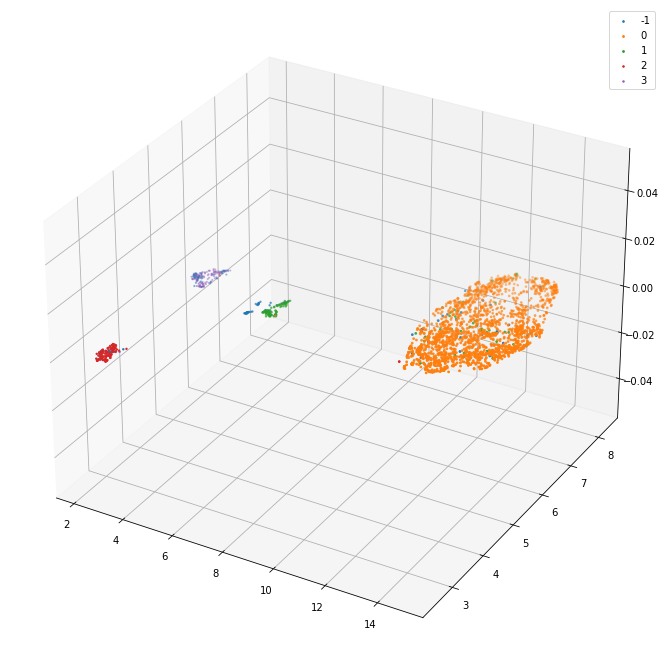

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

for name, group in groups:
    plt.scatter(group.x, group.y, group.z, marker='.', label=name)

plt.legend()

plt.savefig('umap_embedding.png')

### Penalty Codes by Cluster

In [ ]:
cluster0['penaltyCodes'].value_counts()

no penalty    1812
DOF             19
ILF              5
RNK              2
UNR              1
UNRd             1
Name: penaltyCodes, dtype: int64

In [ ]:
cluster1['penaltyCodes'].value_counts()

no penalty    132
UNRd            2
DOF             2
LEA             1
Name: penaltyCodes, dtype: int64

In [ ]:
cluster2['penaltyCodes'].value_counts()

no penalty    109
Name: penaltyCodes, dtype: int64

In [ ]:
cluster3['penaltyCodes'].value_counts()

no penalty    144
Name: penaltyCodes, dtype: int64

In [ ]:
outliers['penaltyCodes'].value_counts()

no penalty    138
OH              1
UNRd            1
RNK             1
Name: penaltyCodes, dtype: int64

In [ ]:
final_df['dc_cluster_id'] = clf.score()

### Visualize Feature Distributions

In [ ]:
import numpy as np

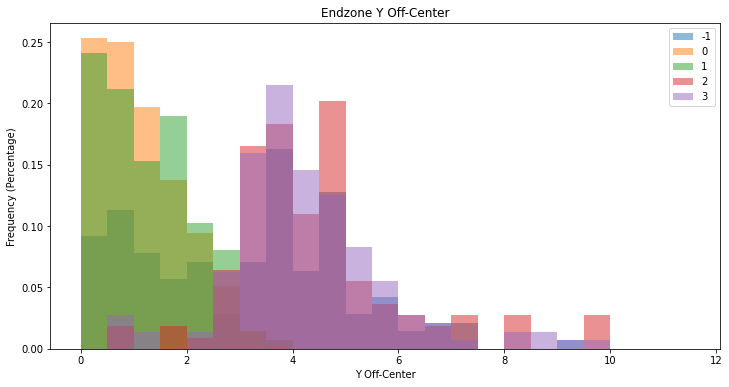

In [ ]:
groups = final_df.groupby('dc_cluster_id')

plt.figure(figsize=(12,6))

for name, group in groups:
    plt.hist(group['endzone_y_off_center'], bins=np.arange(24)/2, weights=np.ones(len(group)) / len(group), label=name, alpha=0.5)

plt.title('Endzone Y Off-Center')
plt.xlabel('Y Off-Center')
plt.ylabel('Frequency (Percentage)')
plt.legend()

plt.savefig('off_center_dist.png')

# Exploring Clusters Visually

In [ ]:
import seaborn as sns

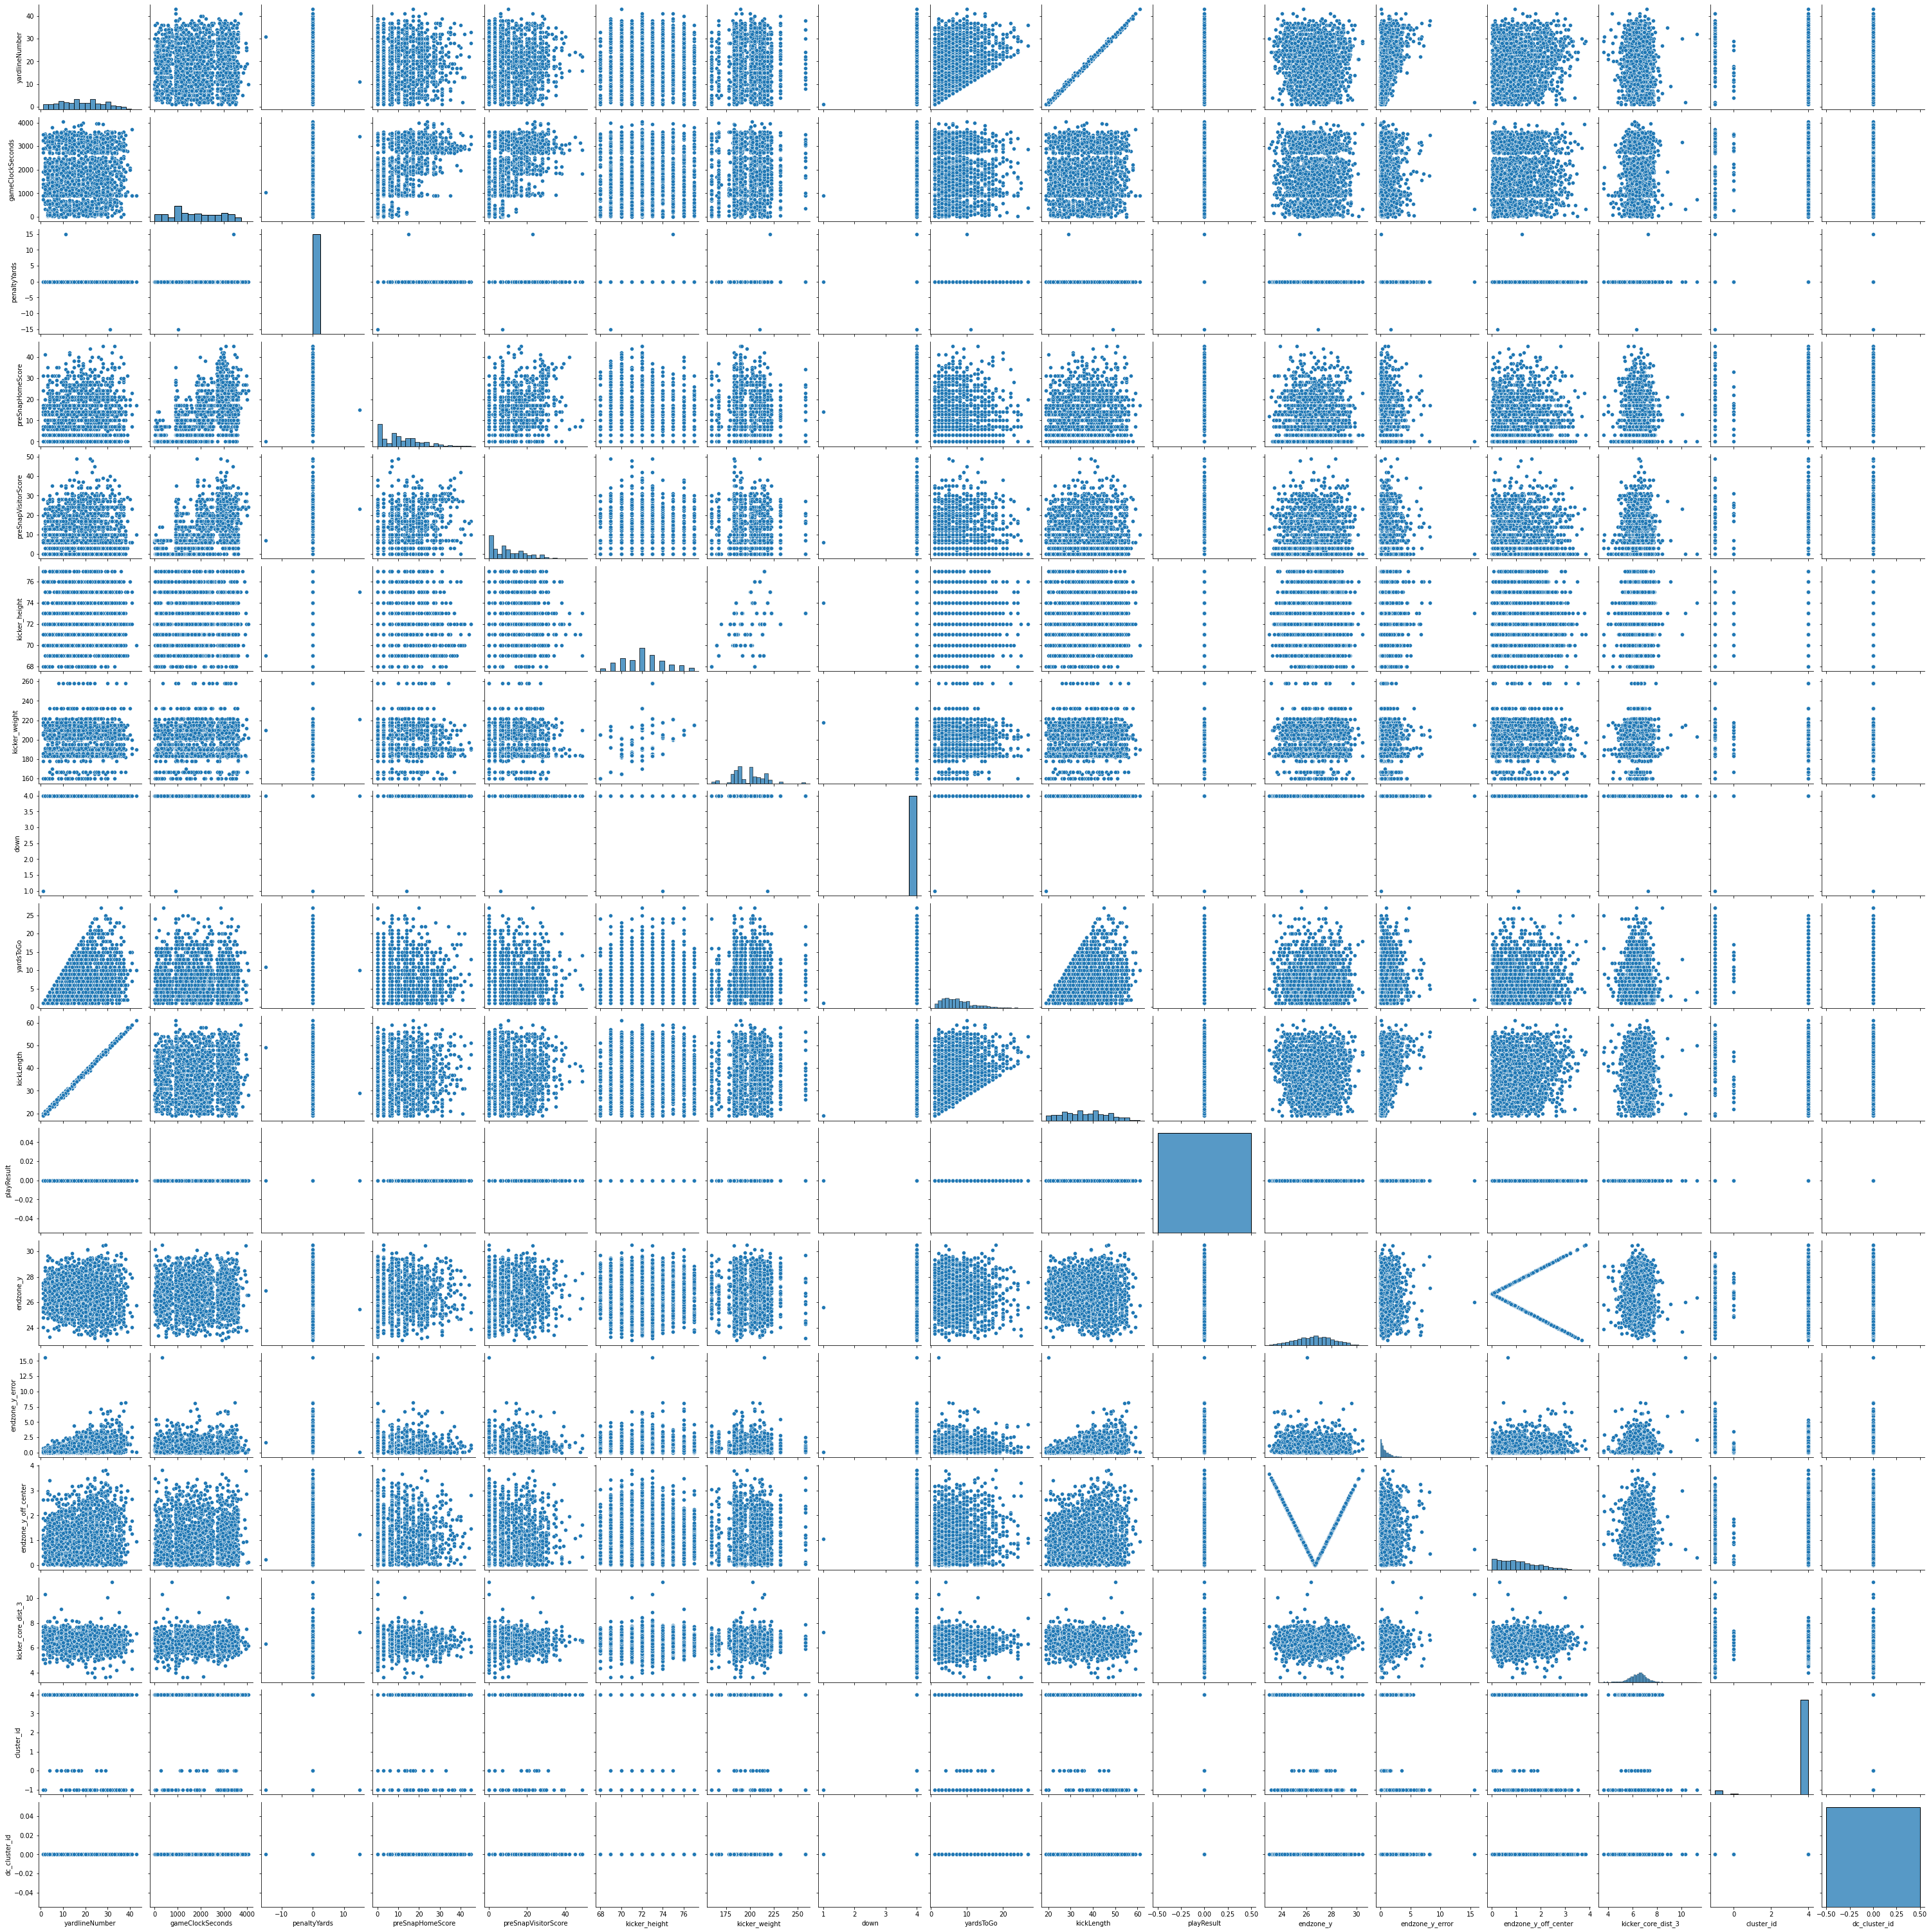

In [ ]:
sns.pairplot(cluster0)

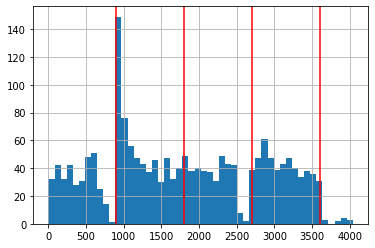

In [ ]:
cluster0['gameClockSeconds'].hist(bins=50)
plt.axvline(900, c='r')
plt.axvline(1800, c='r')
plt.axvline(2700, c='r')
plt.axvline(3600, c='r')

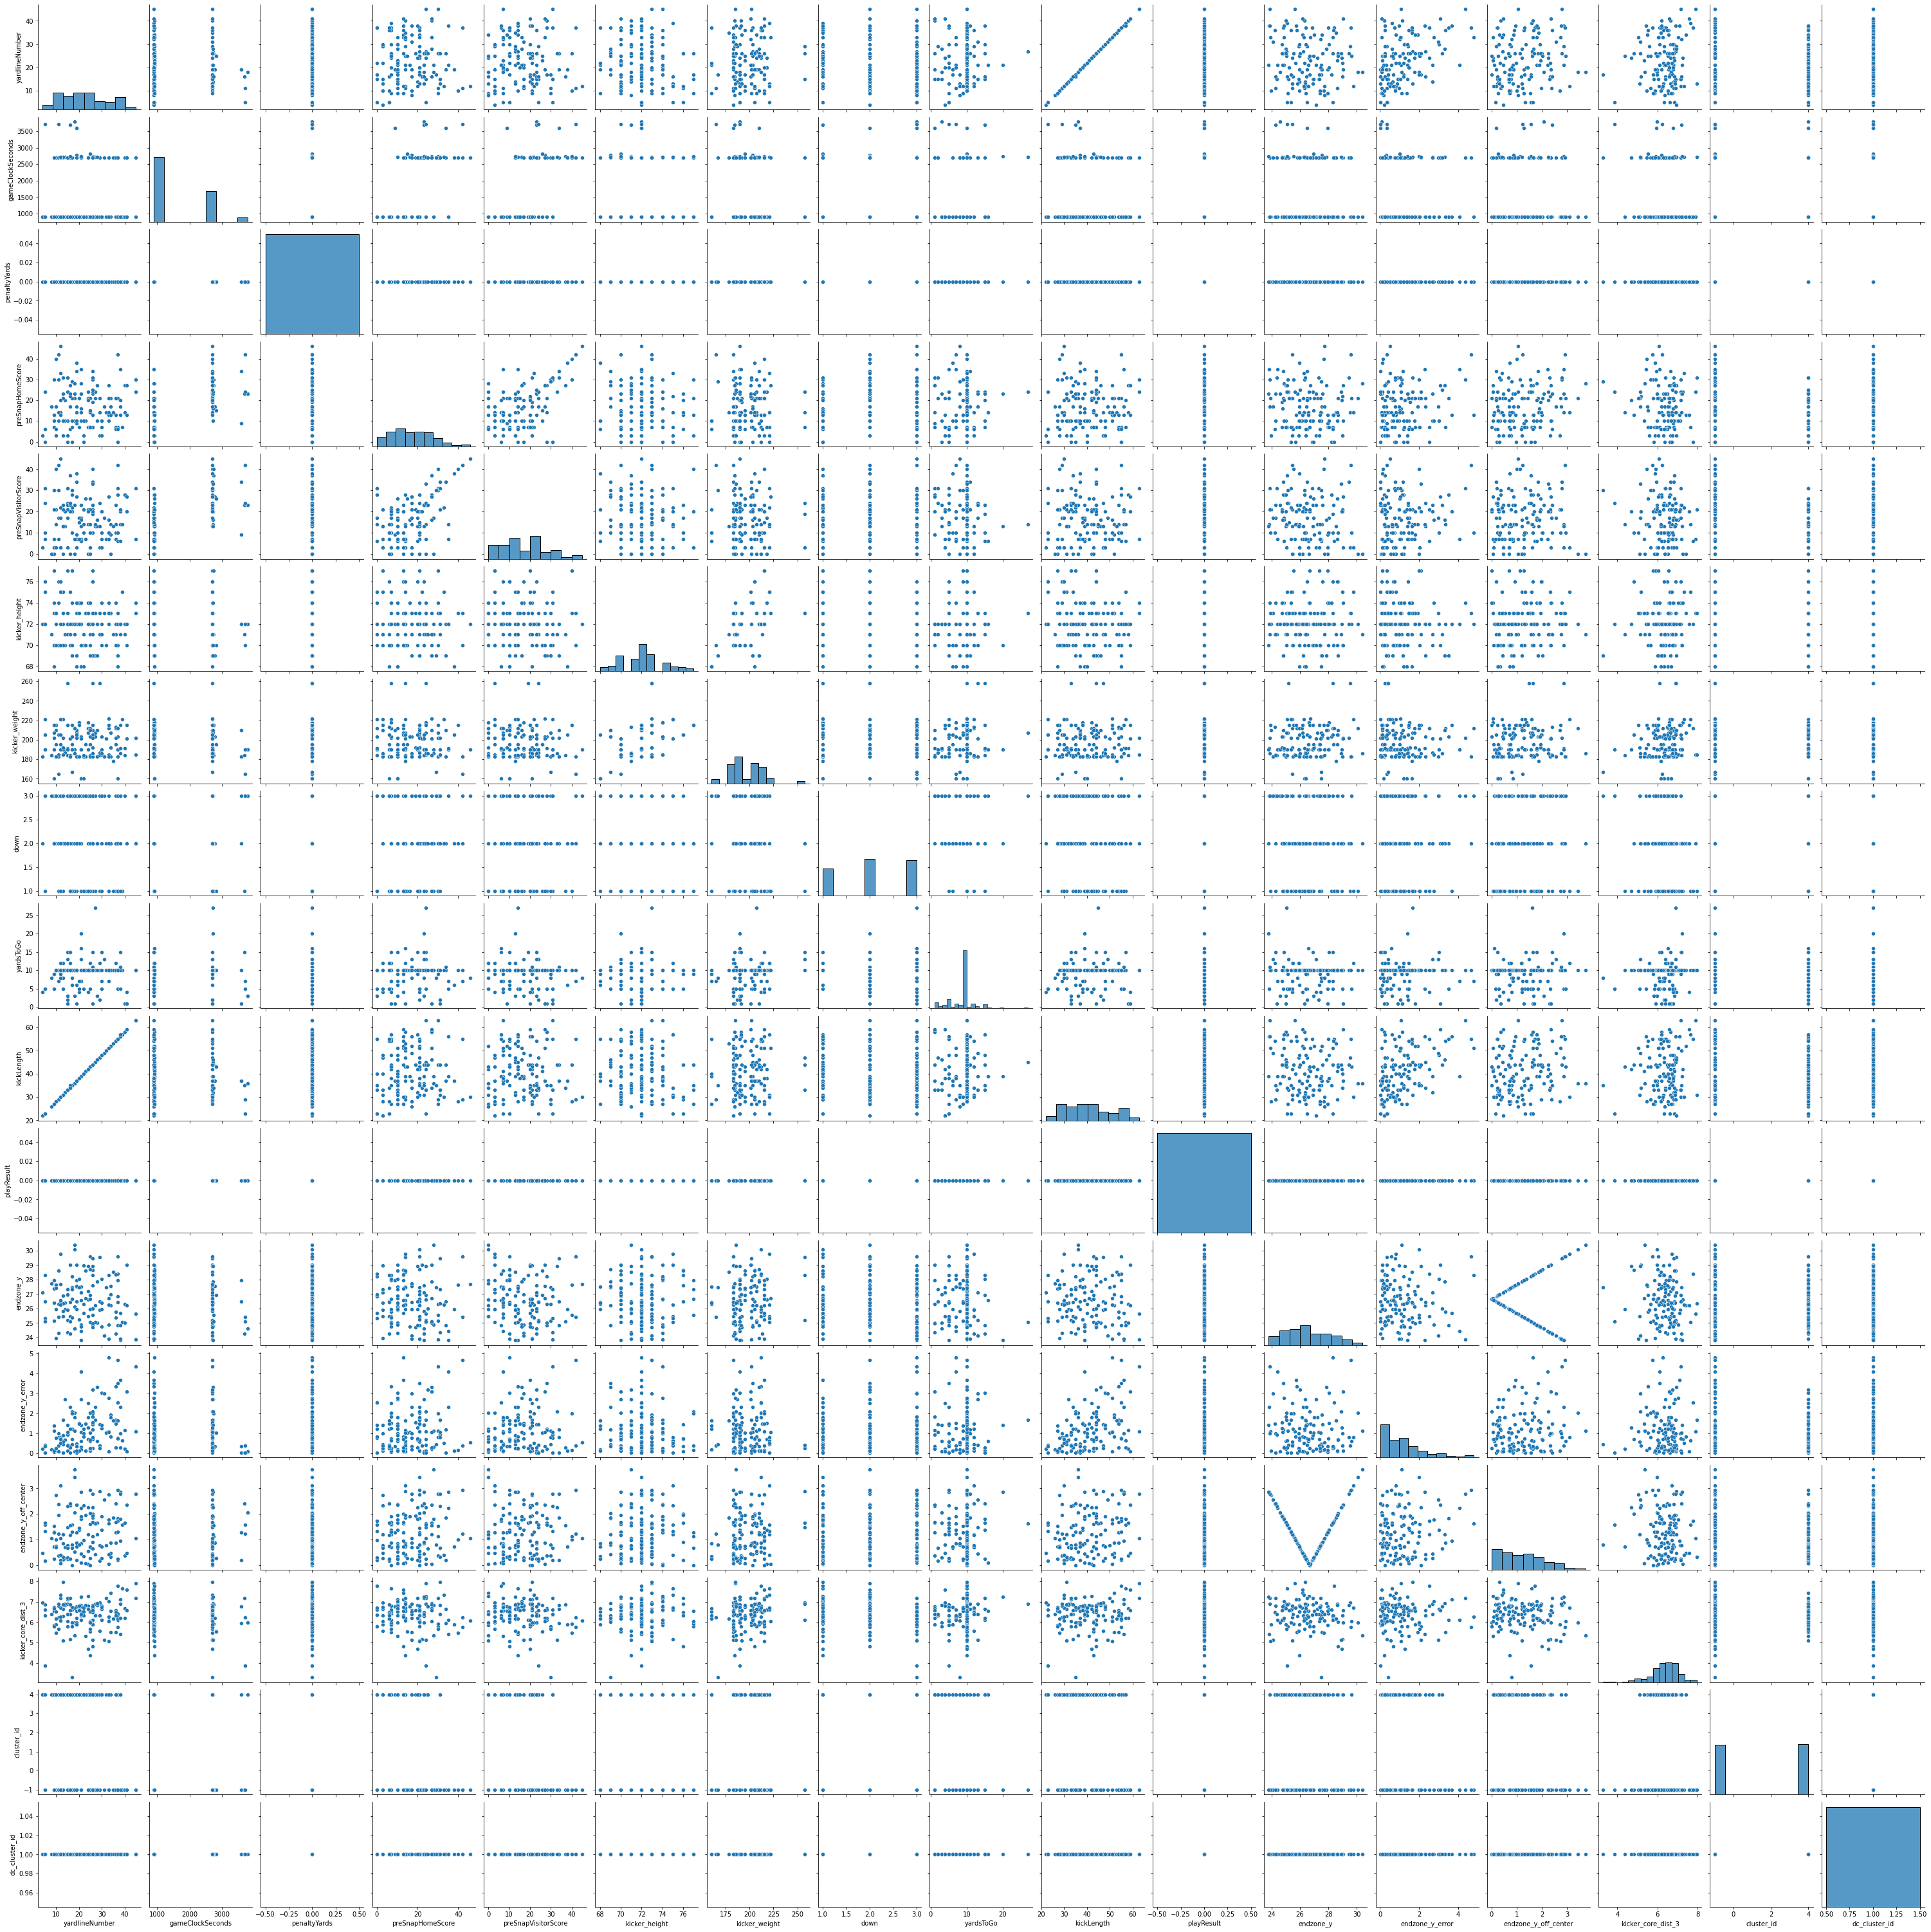

In [ ]:
sns.pairplot(cluster1)

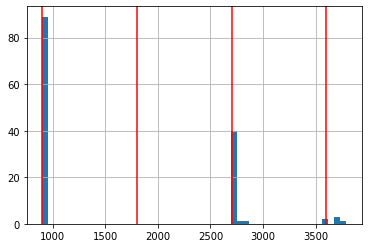

In [ ]:
cluster1['gameClockSeconds'].hist(bins=50)
plt.axvline(900, c='r')
plt.axvline(1800, c='r')
plt.axvline(2700, c='r')
plt.axvline(3600, c='r')

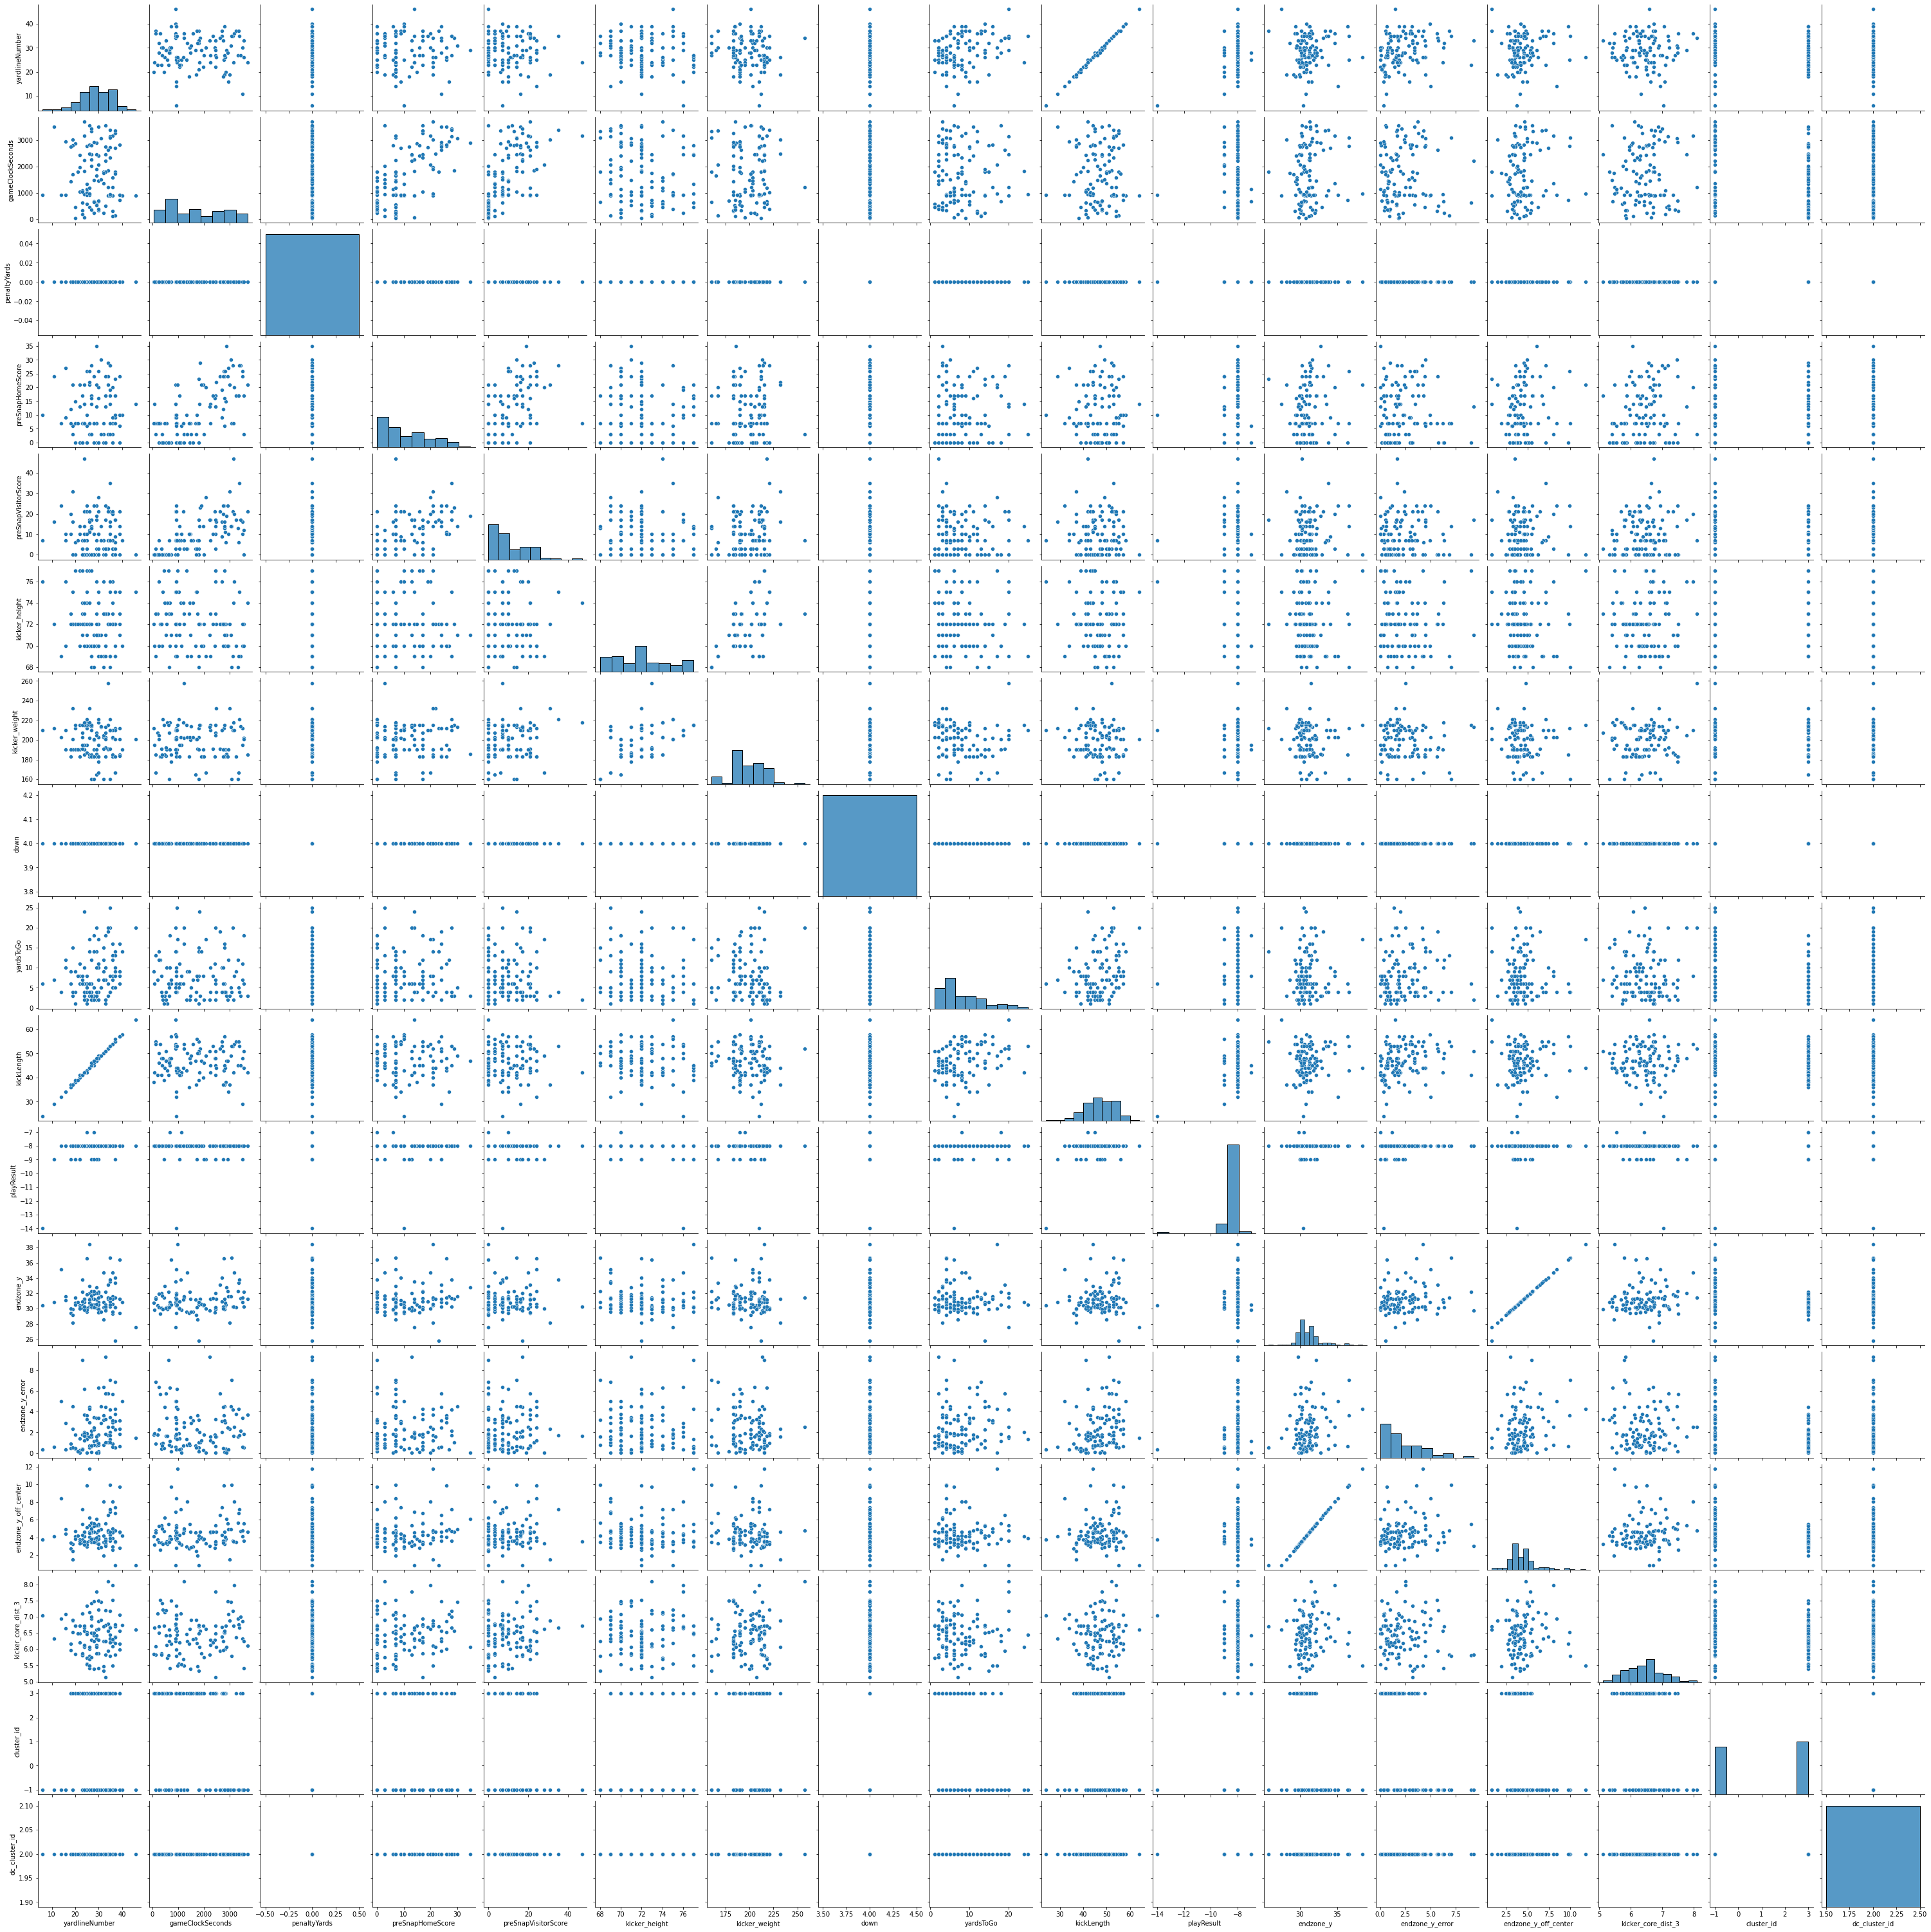

In [ ]:
sns.pairplot(cluster2)

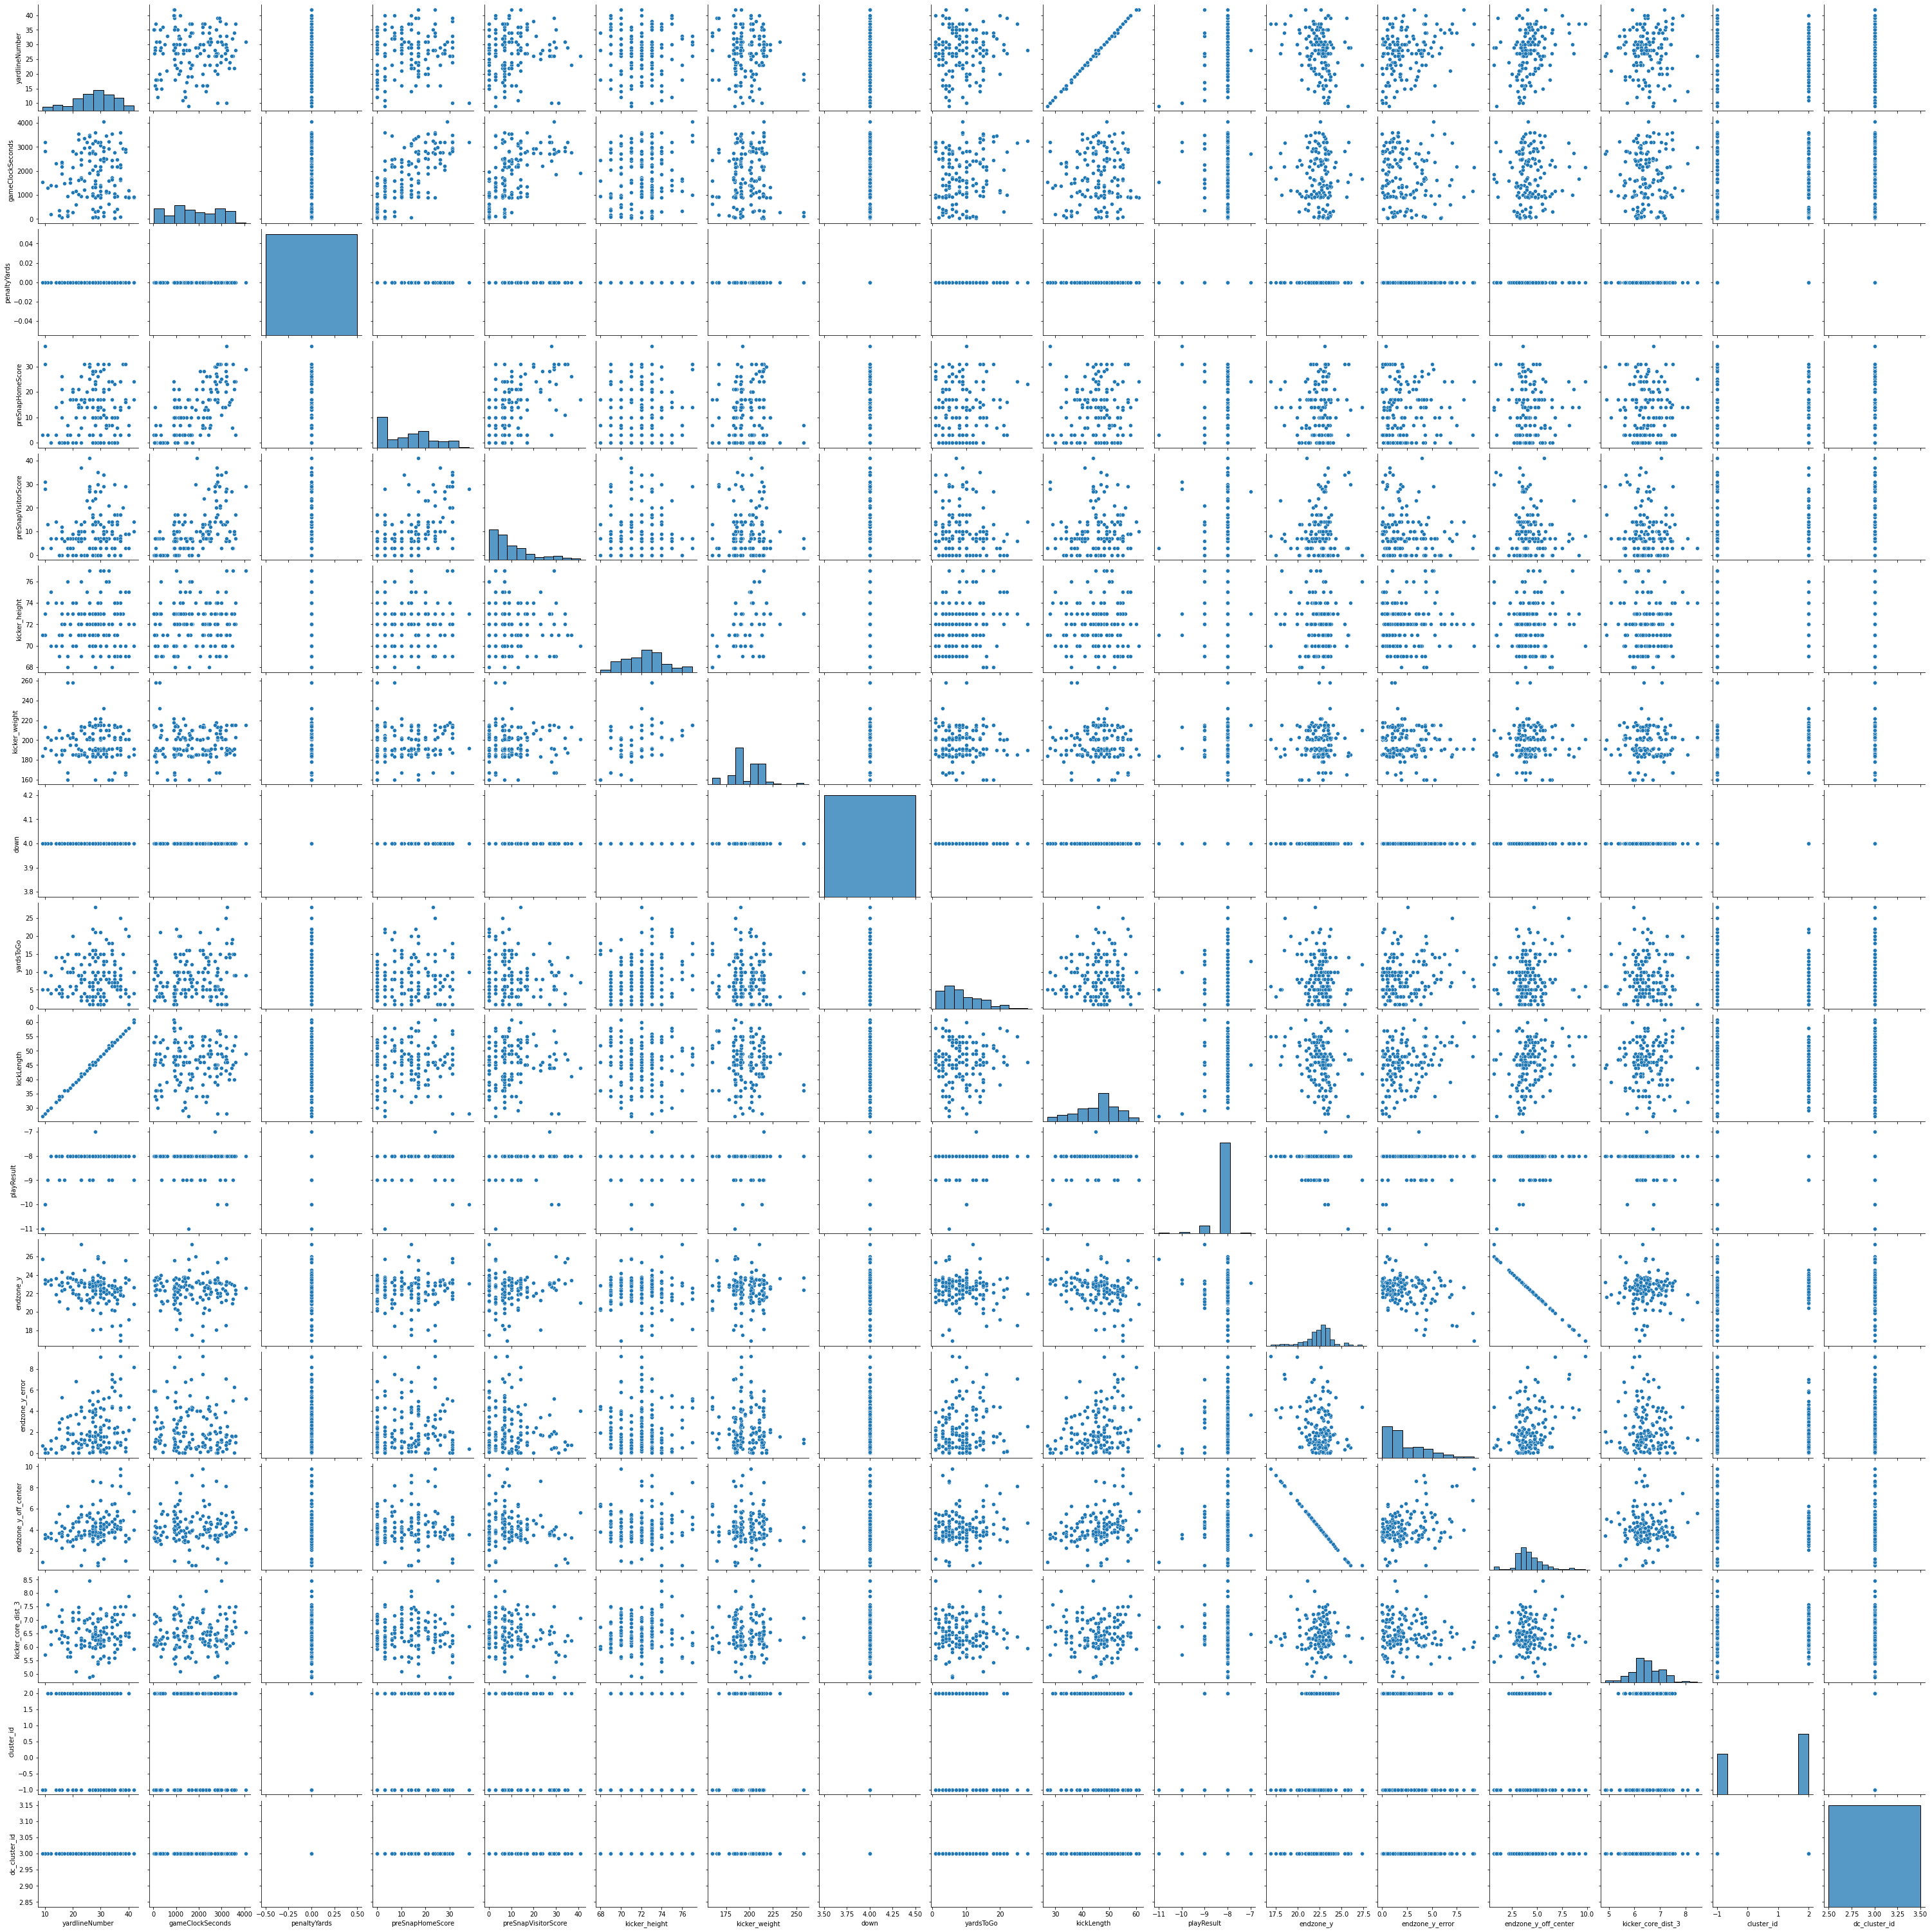

In [ ]:
sns.pairplot(cluster3)

# Clustering on only Engineered Features

In [ ]:
def preprocess_fg(fg_plays):
    '''
    This function the FieldGoal dataframe for clustering.

    Parameters:
    -----------
    fg_plays - FieldGoal dataframe
    ...

    Returns:
    -----------
    fg_scale - processed FieldGoal dataframe

    '''
    #reduce number of columns to those with numeric values or one-hot-encode categoricals
    useful_cols = ['endzone_y_error','endzone_y_off_center']
    
    columns = fg_plays.columns
    
    useful_cols.extend(col for col in columns if 'kicker_core_dist' in col)
    
    #need to drop nulls for clustering
    fg_df = fg_plays[useful_cols].dropna()
    #one-hot-encode SpecialTeamsResult and penaltyCodes
    le_str = LabelEncoder()
    le_pc = LabelEncoder()
    
    #scale data, but only non-categorical columns
    scale = StandardScaler()
    fg_scale = scale.fit_transform(fg_df)
    #TO-DO QUESTION: do we want to scale categoricals too? No
    
    #make this back into a data frame
    fg_scale = pd.DataFrame(fg_scale, columns = fg_df.columns)
    
    return fg_scale, fg_df

In [ ]:
engineered_df = final_df[['endzone_y_error', 'endzone_y_off_center', 'kicker_core_dist_3']]

In [ ]:
engineered_X, engineered_final = preprocess_fg(engineered_df)

/home/kenneth/anaconda3/envs/nfl-env/lib/python3.8/site-packages/matplotlib/collections.py:1003: RuntimeWarning:

invalid value encountered in sqrt



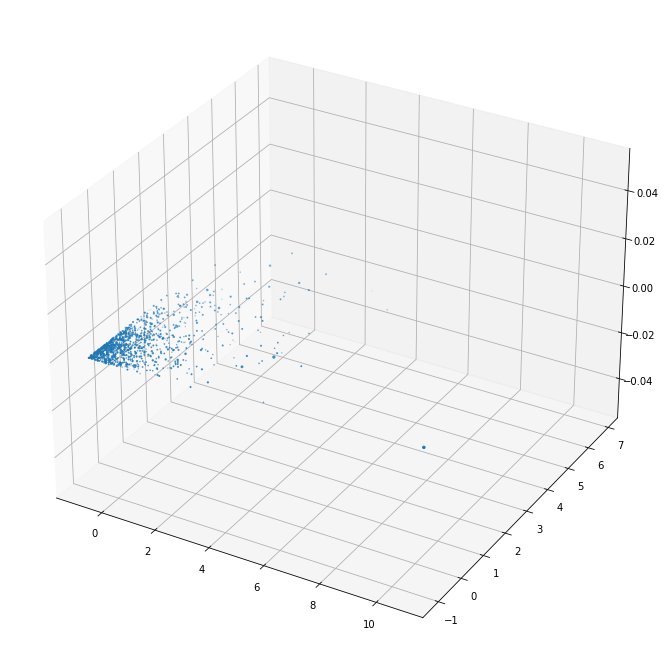

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

plt.scatter(engineered_X['endzone_y_error'], engineered_X['endzone_y_off_center'], engineered_X['kicker_core_dist_3'])

In [ ]:
clusterer = hdbscan.HDBSCAN()

In [ ]:
clusterer.fit(engineered_X)

HDBSCAN()

In [ ]:
clusterer.labels_.max()

2

In [ ]:
engineered_final['cluster_id'] = clusterer.labels_
engineered_final['specialTeamsResult'] = final_df['specialTeamsResult']

In [ ]:
cluster0 = engineered_final[engineered_final['cluster_id']==0]
cluster1 = engineered_final[engineered_final['cluster_id']==1]
cluster2 = engineered_final[engineered_final['cluster_id']==2]

outliers = engineered_final[engineered_final['cluster_id']==-1]

In [ ]:
cluster0['specialTeamsResult'].value_counts()

Kick Attempt No Good    5
Name: specialTeamsResult, dtype: int64

In [ ]:
cluster1['specialTeamsResult'].value_counts()

Kick Attempt No Good    4
Kick Attempt Good       1
Name: specialTeamsResult, dtype: int64

In [ ]:
cluster2['specialTeamsResult'].value_counts()

Kick Attempt Good       1921
Kick Attempt No Good     191
Name: specialTeamsResult, dtype: int64

In [ ]:
outliers['specialTeamsResult'].value_counts()

Kick Attempt No Good    146
Kick Attempt Good       103
Name: specialTeamsResult, dtype: int64

# Breakdown by Kicker

In [ ]:
final_df['kicker_name'] = attempts_df.loc[final_df.index]['kicker_name']

In [ ]:
cluster0 = final_df[final_df['dc_cluster_id']==0]
cluster1 = final_df[final_df['dc_cluster_id']==1]
cluster2 = final_df[final_df['dc_cluster_id']==2]
cluster3 = final_df[final_df['dc_cluster_id']==3]

outliers = final_df[final_df['dc_cluster_id']==-1]

In [ ]:
kick_counts = final_df['kicker_name'].value_counts()

In [ ]:
relevant_kickers = kick_counts[kick_counts > 30].index

In [ ]:
kicker_groups = final_df[final_df['kicker_name'].isin(relevant_kickers)].groupby('kicker_name')

In [ ]:
kicker_groups_mean = kicker_groups.mean()
kicker_groups_std = kicker_groups.std()
kicker_groups_25p = kicker_groups.quantile(.25)
kicker_groups_50p = kicker_groups.quantile(.5)
kicker_groups_75p = kicker_groups.quantile(.75)

<AxesSubplot:>

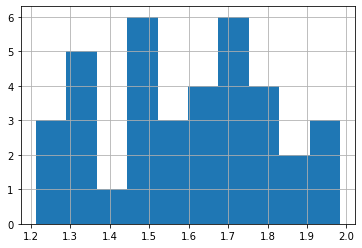

In [ ]:
kicker_groups_mean['endzone_y_off_center'].hist()

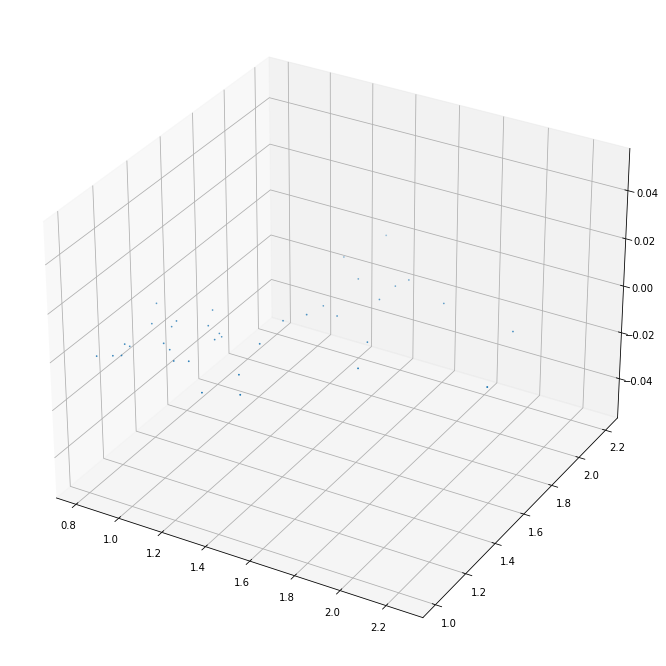

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

plt.scatter(kicker_groups_std['endzone_y_error'], kicker_groups_std['endzone_y_off_center'], kicker_groups_std['kicker_core_dist_3'])

# Animations for Kicker Core

In [ ]:
from animation.play_animation import animate_play

In [ ]:
attempts_df[attempts_df['kicker_core_dist_3'] == attempts_df['kicker_core_dist_3'].min()]

gameId  playId                                    playDescription  \
745  2018122310    4796  (:03) J.Elliott 35 yard field goal is GOOD, Ce...   

     quarter  down  yardsToGo possessionTeam specialTeamsResult  kickerId  \
745        4     3          8            PHI  Kick Attempt Good   44966.0   

    returnerId  ...  gameClockSeconds kicker_height  kicker_weight  \
745        NaN  ...              2703            69            167   

    kicker_position   kicker_name endzone_y  expected_endzone_y  \
745               K  Jake Elliott    27.475           27.908033   

     kicker_core_dist_3  endzone_y_off_center endzone_y_error  
745            3.295285              0.808333        0.433033  

[1 rows x 33 columns]

In [ ]:
attempts_df[attempts_df['kicker_core_dist_3'] == attempts_df['kicker_core_dist_3'].max()]

gameId  playId                                    playDescription  \
712  2018122200     240  (12:14) (Field Goal formation) D.Hopkins 50 ya...   

     quarter  down  yardsToGo possessionTeam specialTeamsResult  kickerId  \
712        1     4          4            WAS  Kick Attempt Good   40125.0   

    returnerId  ...  gameClockSeconds kicker_height  kicker_weight  \
712        NaN  ...               734            74            203   

    kicker_position     kicker_name endzone_y  expected_endzone_y  \
712               K  Dustin Hopkins    26.355           28.428021   

     kicker_core_dist_3  endzone_y_off_center endzone_y_error  
712           11.284224              0.311667        2.073021  

[1 rows x 33 columns]

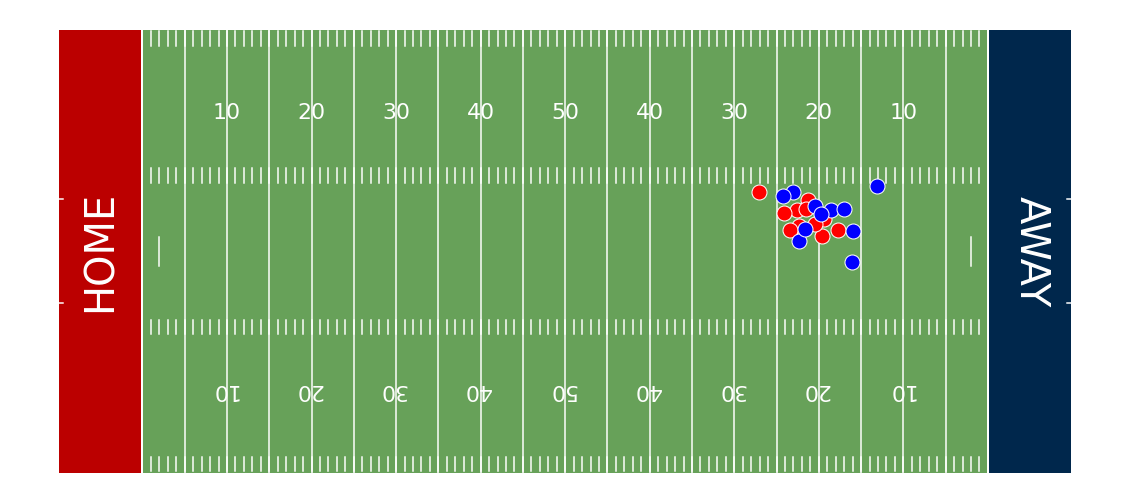

In [ ]:
animate_play(2018122310, 4796, tracking2018, save_to='kicker_core_dist_min.mp4')

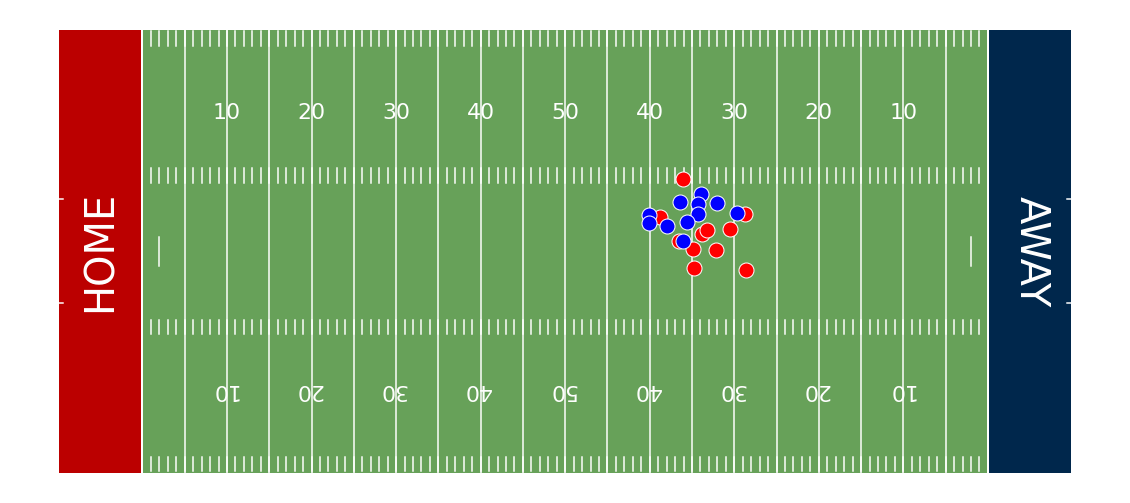

In [ ]:
animate_play(2018122200, 240, tracking2018, save_to='kicker_core_dist_max.mp4')